In [48]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
import numpy as np

import sklearn


In [7]:
def generateData( itemsPerClass=40):
    variance = 0.1
    sigma = np.sqrt(variance)
    no_sample_per_class = itemsPerClass
    classes = [-1,1]
    total_samples = len(classes)*no_sample_per_class
    
    per_group = int(itemsPerClass/2)
    
    x = np.concatenate((
            np.random.normal( 0, sigma, per_group), # x1 for u1
            np.random.normal( 1, sigma, per_group),  # x1 for u2
            np.random.normal( 0, sigma, per_group),  # x1 for u3
            np.random.normal( 1, sigma, per_group),  # x1 for u4
            
            np.random.normal( 1, sigma, per_group),  # x2 for u1
            np.random.normal( 0, sigma, per_group),  # x2 for u2
            np.random.normal( 0, sigma, per_group),  # x2 for u3
            np.random.normal( 1, sigma, per_group),  # x2 for u4
        ))
    x = x.reshape(2,total_samples)
    y = np.zeros(total_samples)
    y[:no_sample_per_class] = -1
    y[no_sample_per_class:] = 1
    return (x, y)

(x_train, y_train) = generateData()

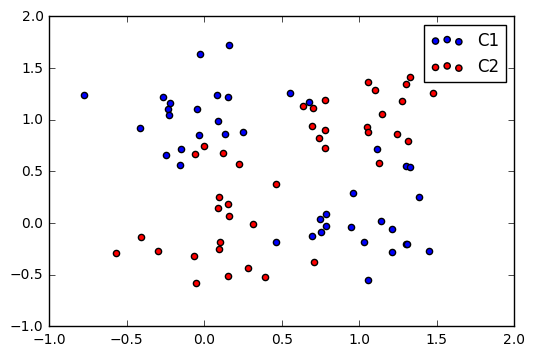

In [10]:
def plotScatter(x,y):
    plt.scatter( x[0,:40] , x[1,:40], c='b', label="C1" )
    plt.scatter( x[0,40:] , x[1,40:], c='r', label="C2" )
    plt.legend()
    
plotScatter(x_train, y_train)

In [13]:
clf = svm.SVC(kernel='rbf')
clf.fit(x_train.T,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
(x_test, y_test) = generateData()

In [19]:
pred_y = clf.predict(x_test.T)
acc = accuracy_score( y_test, pred_y)
print("Accuracy %.4f" % acc )
print("Percentage of wrong prediction %.4f" %  (1-acc) )

Accuracy 0.8625
Percentage of wrong prediction 0.1375


In [27]:
h = 0.02
x_min, x_max = x_train[0,:].min() - 0.5, x_train[0,:].max() + 0.5
y_min, y_max = x_train[1,:].min() - 0.5, x_train[1,:].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
xx_r = xx.ravel()
yy_r = yy.ravel()
    
xx_yy = np.concatenate((xx_r, yy_r)).reshape( (2,len(xx_r)) )
print(xx_yy.T.shape)
pred_1nn = clf.predict(xx_yy.T)


(27058, 2)


# H8.2

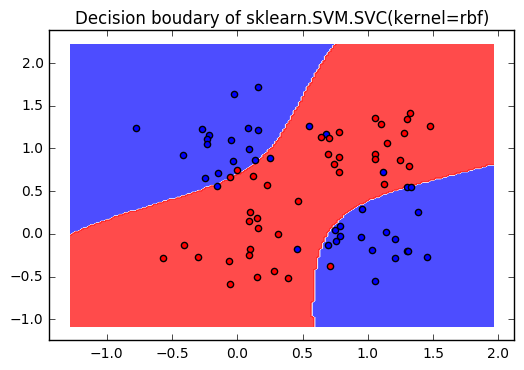

In [28]:
def plotContour( x, pred, title, colors=('b','r')):
    Z = pred.reshape(xx.shape)
    plt.contourf(xx, yy, Z,  cmap=plt.cm.bwr, alpha=0.8)
    for i in range(len(colors)):
        s = (i)*40
        n = (i+1)*40
        plt.scatter( x[0,s:n] , x[1,s:n], c= colors[i] )
    plt.title(title)
    
plotContour( x_train, pred_1nn, "Decision boudary of sklearn.SVM.SVC(kernel=rbf)")

# H8.3

In [140]:
C_power = np.arange(-6, 11, 2) 
C_range = np.power( 2.0, C_power ) # generate [-6,10]

gamma_power =  np.arange(-5, 10, 2) 
gamma_range = np.power( 2.0, gamma_power)

param_grid = { 
    'C': C_range,
    'gamma': gamma_range
}


In [106]:
grid_clf = GridSearchCV( svm.SVC(kernel='rbf'), param_grid, cv=5, scoring="accuracy")

grid_clf.fit(x_train.T, y_train)
print(grid_clf.best_params_)

{'gamma': 8.0, 'C': 0.015625}


In [105]:
def extract_params(grid_scores):
    
    accs = []
    gammas = []
    cs = []
    for i in range(len(grid_scores)):
        params, acc, _ = grid_scores[i]
        accs.append(acc)
        gammas.append(params['gamma'])
        cs.append(params['C'])

    return accs, gammas, cs

res_means, res_gammas, res_C = extract_params(grid_clf.grid_scores_)

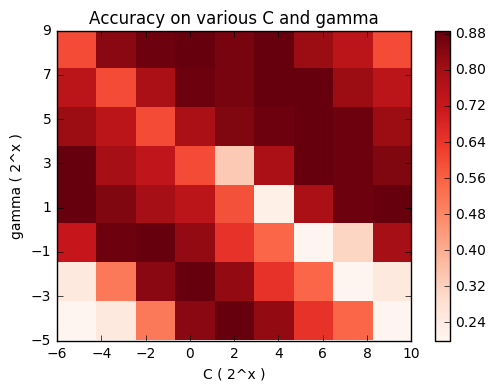

In [166]:
# C first then, gamma
heat_accs = np.array(res_means).reshape( (len(gamma_range), len(C_range)) )

extent=( C_power[0],C_power[-1],gamma_power[0],gamma_power[-1])

plt.imshow( heat_accs, cmap='Reds', extent=extent,  interpolation='nearest', origin='lower')
plt.xticks(C_power)
plt.yticks(gamma_power)
plt.colorbar()
plt.xlabel("C ( 2^x )")
plt.ylabel("gamma ( 2^x )")
plt.title("Accuracy on various C and gamma")
plt.show()

In [167]:
print("Best params")
print(grid_clf.best_params_)

Best params
{'gamma': 8.0, 'C': 0.015625}


In [173]:
best_clf = svm.SVC( kernel='rbf', C=0.015625, gamma=8.0 )
best_clf.fit(x_train.T, y_train)

SVC(C=0.015625, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=8.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

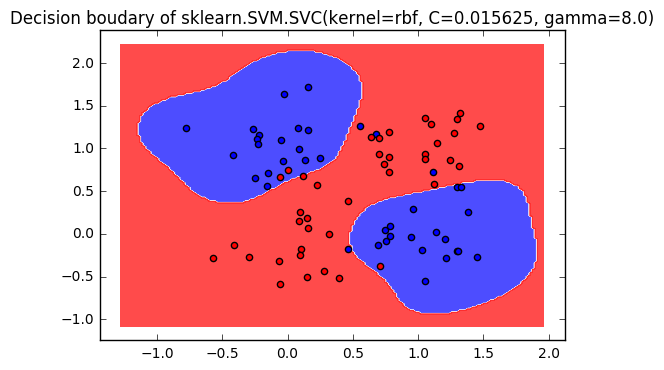

In [179]:
pred_with_best_clf = best_clf.predict(xx_yy.T)
plotContour( x_train, pred_with_best_clf, "Decision boudary of sklearn.SVM.SVC(kernel=rbf, C=0.015625, gamma=8.0)")

In [175]:
pred_y_with_best = best_clf.predict(x_test.T)
acc = accuracy_score( y_test, pred_y_with_best)
print("Accuracy %.4f" % acc )
print("Percentage of wrong prediction %.4f" %  (1-acc) )

Accuracy 0.9125
Percentage of wrong prediction 0.0875


In [180]:
adj_clf = svm.SVC( kernel='rbf', C=0.015625/4, gamma=8.0/4 )
adj_clf.fit(x_train.T, y_train)

SVC(C=0.00390625, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

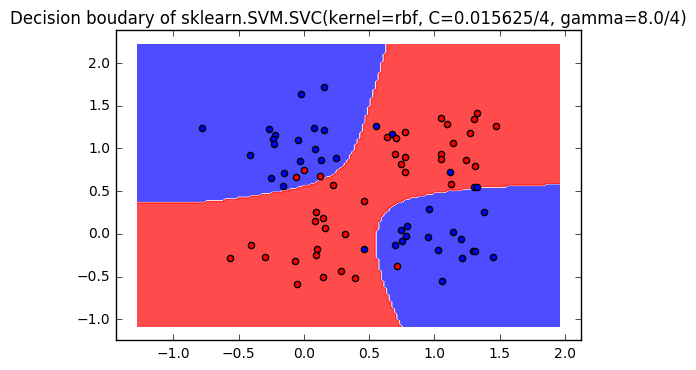

In [181]:
pred_with_adj_clf = adj_clf.predict(xx_yy.T)
plotContour( x_train, pred_with_adj_clf, "Decision boudary of sklearn.SVM.SVC(kernel=rbf, C=0.015625/4, gamma=8.0/4)")

In [182]:
pred_y_with_adj =adj_clf.predict(x_test.T)
acc = accuracy_score( y_test, pred_y_with_adj)
print("Accuracy %.4f" % acc )
print("Percentage of wrong prediction %.4f" %  (1-acc) )

Accuracy 0.9000
Percentage of wrong prediction 0.1000


## sign of overfitting/underfitting
It seems to show a sign of overfitting as the decision boudary has more curves when comparing to the default model.

## after dividing C and Gamma with 4
the decision boundary becomes smoother as C